In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imwrite

from fcn import VGGNet, FCNs
from dataset import SegmentationDataset, LabelToOnehot, imshow
from train import train_model, visualize_model

from horsetools import list_files

plt.ion()

## Find normalization constants for data

In [2]:
# find means and stds of dataset
imgs_list = list_files('stroma_epithelia/images')
np_means = np.zeros((len(imgs_list), 3))
np_stds = np.zeros_like(np_means)
for i, img_name in enumerate(imgs_list):
    img = imread(img_name)
    np_means[i] = np.mean(img, axis=(0, 1))
    np_stds[i] = np.std(img, axis=(0, 1))
    
channel_means = np.mean(np_means, axis=0)
channel_stds = np.std(np_stds, axis=0)

In [3]:
print('Means: {}'.format(channel_means))
print('Stds: {}'.format(channel_stds))

Means: [164.60564156 150.75147313 178.36823845]
Stds: [ 9.46653235 16.23701039  9.48000306]


## Define dataloaders

In [4]:
data_root = 'stroma_epithelia'
crop_size = 224
labels = (0, 1, 2)
dataset_phases = ['train']

n_labels = len(labels)

In [5]:
data_transforms = {
    'train': {
        'imgs': transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(channel_means, channel_stds)
        ]),
        'masks': transforms.Compose([
            transforms.CenterCrop(crop_size),
            LabelToOnehot(labels),
            transforms.ToTensor()
        ])
    }
}

image_datasets = {x: SegmentationDataset(data_root, labels, 
                                         image_transforms=data_transforms[x]['imgs'],
                                         mask_transforms=data_transforms[x]['masks'])
                  for x in dataset_phases}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, 
                             shuffle=True, num_workers=4)
               for x in dataset_phases}
dataset_sizes = {x: len(image_datasets[x]) for x in dataset_phases}

## Compare label and mask

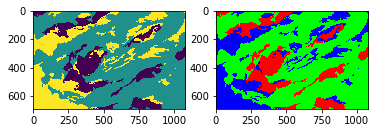

In [6]:
mask_name = 'stroma_epithelia/masks/0.1_110_2_1.png'
mask = imread(mask_name)
LO = LabelToOnehot(labels)
mask_oh = LO(mask)

plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(mask_oh)

## Visualize images

Image shape: torch.Size([4, 3, 224, 224])
Masks shape: torch.Size([4, 3, 224, 224])


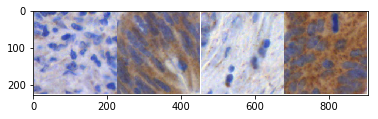

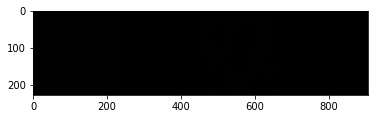

In [7]:
inputs, masks = next(iter(dataloaders['train']))
print('Image shape: {}'.format(inputs.shape))
print('Masks shape: {}'.format(masks.shape))
imshow(torchvision.utils.make_grid(inputs), means=channel_means, stds=channel_stds)
imshow(torchvision.utils.make_grid(masks))

## Define model

In [8]:
learn_rate = 0.001
momentum = 0.9
step_size = 50
gamma = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_labels)

fcn_model = fcn_model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.SGD(fcn_model.parameters(), lr=learn_rate, momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

/home/masonmcgough/anaconda2/envs/PyTorchSIIM/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


## Train and evaluate

In [9]:
# import importlib
# import train
# importlib.reload(train)
# train_model = train.train_model

fcn_model = train_model(fcn_model, dataloaders, criterion, optimizer_ft, scheduler, 
                        dataset_phases, dataset_sizes, device=device, num_epochs=25)
visualize_model(fcn_model, dataloaders, labels)

Epoch 0 / 24
----------


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCStorage.cu:58